# This notebook is for fairness and diversity validation for our ADS

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import ADS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Fairness validation
- Focus on the group fairness validation considering sensitive attribute gender, age and whether-smoking.
- Group fairness methodology includes 3 measures proposed in [Measuring Fairness in Ranked Outputs](https://arxiv.org/abs/1610.08559).
- Validation is done on different groups defined by above sensitive attributes.
- We also validate the cross impact between multiple sensitive attributes.

In [2]:
# run the simple linear regression for multiple test sets, given the same test set size but randomly update the test size
def run_regression(_data, model_name="linear", test_ratio=0.33, run_times=100):
    sensi_group_map = {"sex":{0: "female", 1: "male"},
                       "age":{1: "young", 0: "old"},
                       "bmi":{1: "obesity", 0: "non-obesity"},
                       "children":{1: "have children", 0: "no child"},
                       "smoker":{1: "smoker", 0: "non-smoker"}}
                       
    # binarize age, bmi, and children
    _data.loc[_data["age"] < 25, "age"] = 1 # young
    _data.loc[_data["age"] >= 25, "age"] = 0 # old
    _data.loc[_data["bmi"] < 30, "bmi"] = 0 # non-obesity
    _data.loc[_data["bmi"] >= 30, "bmi"] = 1 # obesity 
    _data.loc[_data["children"] > 0, "children"] = 1 # have children
    
    att_list = _data.columns[0:-2] # get all the sensitive atts
    
    res_df = pd.DataFrame(columns=["run_time", "overall_acc", "sensi_att", "sensi_group", "group_acc", "group_ppv"])
    for ri in range(run_times):
        data_train, data_test = train_test_split(_data, test_size=test_ratio, random_state=ri)
        
        cur_model, overall_acc = call_regression_model(model_name, data_train, data_test)
        for ai in att_list: # compute the acc for every subpopultation
            for vi in [1, 0]:
                cur_acc = compute_group_acc(model_name, cur_model, data_test[data_test[ai]== vi], data_test)
                cur_ppv = compute_ppv_group(model_name, cur_model, data_test[data_test[ai]== vi], data_test)
                res_df.loc[res_df.shape[0]] = [ri, overall_acc, ai, sensi_group_map[ai][vi], cur_acc, cur_ppv]
    return res_df
def call_regression_model(_model_name, _train_data, _test_data):
    if _model_name == "linear":
        r_model = ADS.simpleLR(_train_data)
        X_test, y_test = ADS.prepareLR(_test_data)
        r_msr = r_model.score(X_test, y_test)
    elif _model_name == "polynomial":
        r_model = ADS.polynomialLR(_train_data)
        X_test, y_test = ADS.preparePoly(_test_data)
        r_msr = r_model.score(X_test, y_test)
    else: # random forest
        r_model = ADS.forest(_train_data)
        X_test, y_test = ADS.prepareForest(_test_data)
        y_pred = r_model.predict(X_test)
        r_msr = r2_score(y_test, y_pred)
    return r_model, r_msr
def compute_group_acc(_model_name, _model, _group_test_data, _all_test_data):
    if _model_name == "linear":
        X_test, y_test = ADS.prepareLR(_group_test_data)
        if len(y_test) != len(_all_test_data) and len(y_test) > 0:
            return _model.score(X_test, y_test)
        else:
            return -1
    elif _model_name == "polynomial":
        X_test, y_test = ADS.preparePoly(_group_test_data)
        if len(y_test) != len(_all_test_data) and len(y_test) > 0:
            return _model.score(X_test, y_test)
        else:
            return -1
    else: # random forest
        X_test, y_test = ADS.prepareForest(_group_test_data)
        if len(y_test) != len(_all_test_data) and len(y_test) > 0:
            y_pred = _model.predict(X_test)
            return r2_score(y_test, y_pred)
        else:
            return -1
# function to compute PPV
def compute_ppv_group(_model_name, _model, _group_test_data, _all_test_data, y_threshold = 20000):
    if _model_name == "linear":
        X_test, y_test = ADS.prepareLR(_group_test_data)
    elif _model_name == "polynomial":
        X_test, y_test = ADS.preparePoly(_group_test_data)
    else: # random forest
        X_test, y_test = ADS.prepareForest(_group_test_data)
    
    if len(y_test) != len(_all_test_data) and len(y_test) > 0:
        y_pred = _model.predict(X_test)
        if  len([x for x in y_pred if x >= y_threshold]) > 0:
            if _model_name == "polynomial": # for polynomial, the data type is different
                cur_tp = len([idx for idx, x in enumerate(y_pred) if x >= y_threshold and _all_test_data.loc[_group_test_data.iloc[idx,:].name, "charges"] >= y_threshold])
                cur_fp = len([idx for idx, x in enumerate(y_pred) if x >= y_threshold and _all_test_data.loc[_group_test_data.iloc[idx,:].name, "charges"] < y_threshold])
            else:
                cur_tp = len([idx for idx, x in enumerate(y_pred) if x >= y_threshold and _all_test_data.loc[X_test.iloc[idx,:].name, "charges"] >= y_threshold])
                cur_fp = len([idx for idx, x in enumerate(y_pred) if x >= y_threshold and _all_test_data.loc[X_test.iloc[idx,:].name, "charges"] < y_threshold])
            
            if len([x for x in y_pred if x >= y_threshold]) != (cur_tp + cur_fp):
                print ("Wrong!")
            else:
                pass
            return round(cur_tp/(cur_tp+cur_fp), 2)
        else:
            return -1
    else:
        return -1

## Show the performance for sub-populations
- Performance is measured by accuracy metric: mean squared error rate
- We consider 5 sensitive attributes: sex, age, bmi, children, smoker
- The sub-populations defined by above attributes are the following:
    - Sex: female and male
    - Age: young (age < 25) and old (age >= 25)
    - BMI: obesity (bmi >=30) and non-obesity (bmid < 30)
    - Children: have children (children > 0) and no child (children == 0)
    - Smoker: smoker and non-smoker

In [3]:
# input data
data = pd.read_csv("insurance.csv")
data = ADS.encode(data)
simple_res = run_regression(data, model_name="linear")
simple_res.head(5)

,run_time,overall_acc,sensi_att,sensi_group,group_acc,group_ppv
0,0,0.727479,age,young,0.712617,0.68
1,0,0.727479,age,old,0.724952,0.85
2,0,0.727479,sex,male,0.765172,0.86
3,0,0.727479,sex,female,0.658041,0.73
4,0,0.727479,bmi,obesity,0.800157,1.00


In [4]:
# input data
data = pd.read_csv("insurance.csv")
data = ADS.encode(data)
poly_res = run_regression(data, model_name="polynomial")
poly_res.head(5)

,run_time,overall_acc,sensi_att,sensi_group,group_acc,group_ppv
0,0,0.832943,age,young,0.825266,1.00
1,0,0.832943,age,old,0.830994,0.85
2,0,0.832943,sex,male,0.857403,0.89
3,0,0.832943,sex,female,0.788010,0.84
4,0,0.832943,bmi,obesity,0.882052,1.00


In [5]:
# input data
data = pd.read_csv("insurance.csv")
data = ADS.encode(data)
rf_res = run_regression(data, model_name="random")
rf_res.head(5)

,run_time,overall_acc,sensi_att,sensi_group,group_acc,group_ppv
0,0,0.811349,age,young,0.783734,1.00
1,0,0.811349,age,old,0.814443,0.85
2,0,0.811349,sex,male,0.846167,0.89
3,0,0.811349,sex,female,0.748018,0.84
4,0,0.811349,bmi,obesity,0.864546,1.00


## Compute group fairness for sub-populations
- Group fairness measure is predict positive rate PPV) by defining positive as precited charges >= 20000. 
    - There are around 20% (273/1338) population with the positive label.
- We test the group fairness given different train-test splits.

In [6]:
# input data
train_ratio_list = [x/100 for x in range(50, 100) if x%5==0]
model_list = ["linear", "polynomial", "random"]
gf_res = pd.DataFrame(columns=["train_ratio","regression_model", "run_time", "overall_acc", "sensi_att", "sensi_group", "group_acc", "group_ppv"])
for ti in train_ratio_list:
    for mi in model_list:
        data = pd.read_csv("insurance.csv")
        data = ADS.encode(data)
        cur_res = run_regression(data, model_name=mi, test_ratio=1-ti, run_times=100)
        cur_res["train_ratio"] = ti

        cur_res["regression_model"] = mi
        cur_res = cur_res.loc[:, gf_res.columns]
        gf_res = pd.concat([gf_res, cur_res])

In [7]:
gf_res.head(10)

,train_ratio,regression_model,run_time,overall_acc,sensi_att,sensi_group,group_acc,group_ppv
0,0.5,linear,0,0.70134,age,young,0.744918,0.69
1,0.5,linear,0,0.70134,age,old,0.679332,0.84
2,0.5,linear,0,0.70134,sex,male,0.749721,0.84
3,0.5,linear,0,0.70134,sex,female,0.618964,0.75
4,0.5,linear,0,0.70134,bmi,obesity,0.802914,1.00
5,0.5,linear,0,0.70134,bmi,non-obesity,0.205829,0.53
6,0.5,linear,0,0.70134,children,have children,0.657339,0.81
7,0.5,linear,0,0.70134,children,no child,0.757632,0.80
8,0.5,linear,0,0.70134,smoker,smoker,0.371015,0.80
9,0.5,linear,0,0.70134,smoker,non-smoker,-0.048543,-1.00


## Visualize the accuracy of sub-populations for a given train-test split

### Linear regression

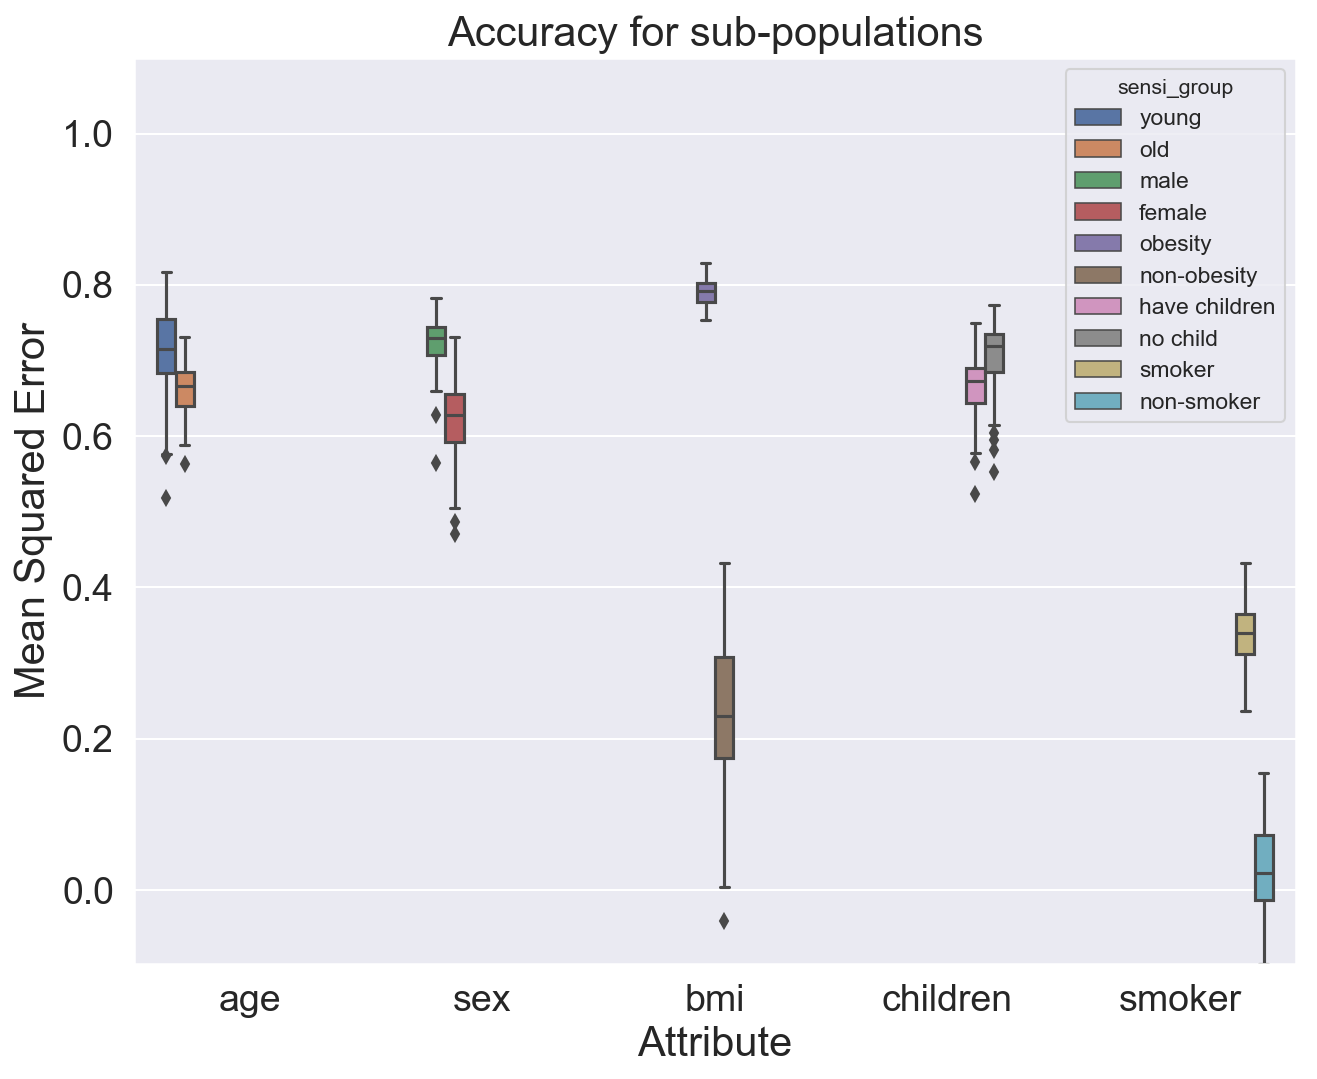

In [13]:
plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="sensi_att", y="group_acc", hue="sensi_group", data=simple_res)
plt.xlabel("Attribute", fontsize=20)
plt.ylabel("Mean Squared Error", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([min(simple_res["group_acc"]),1.1])
plt.title("Accuracy for sub-populations", fontsize=20)
plt.savefig("Accuracy_lr.png")

### Polynomial regression

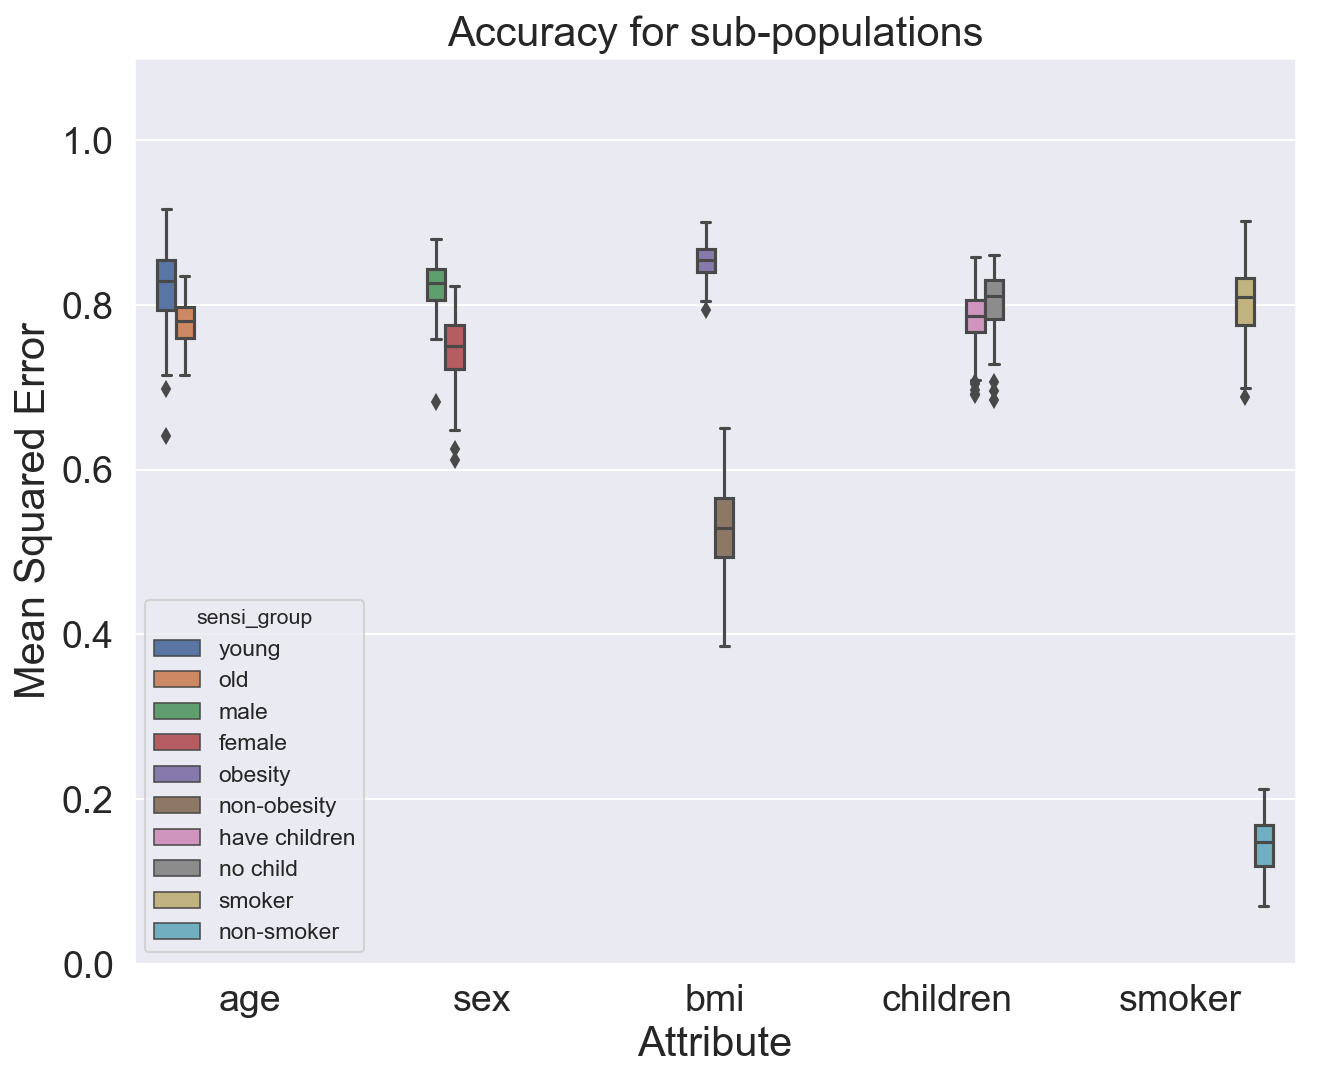

In [16]:
plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="sensi_att", y="group_acc", hue="sensi_group", data=poly_res)
plt.xlabel("Attribute", fontsize=20)
plt.ylabel("Mean Squared Error", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0,1.1])
plt.title("Accuracy for sub-populations", fontsize=20)
plt.savefig("Accuracy_pl.png")

### Random Forest

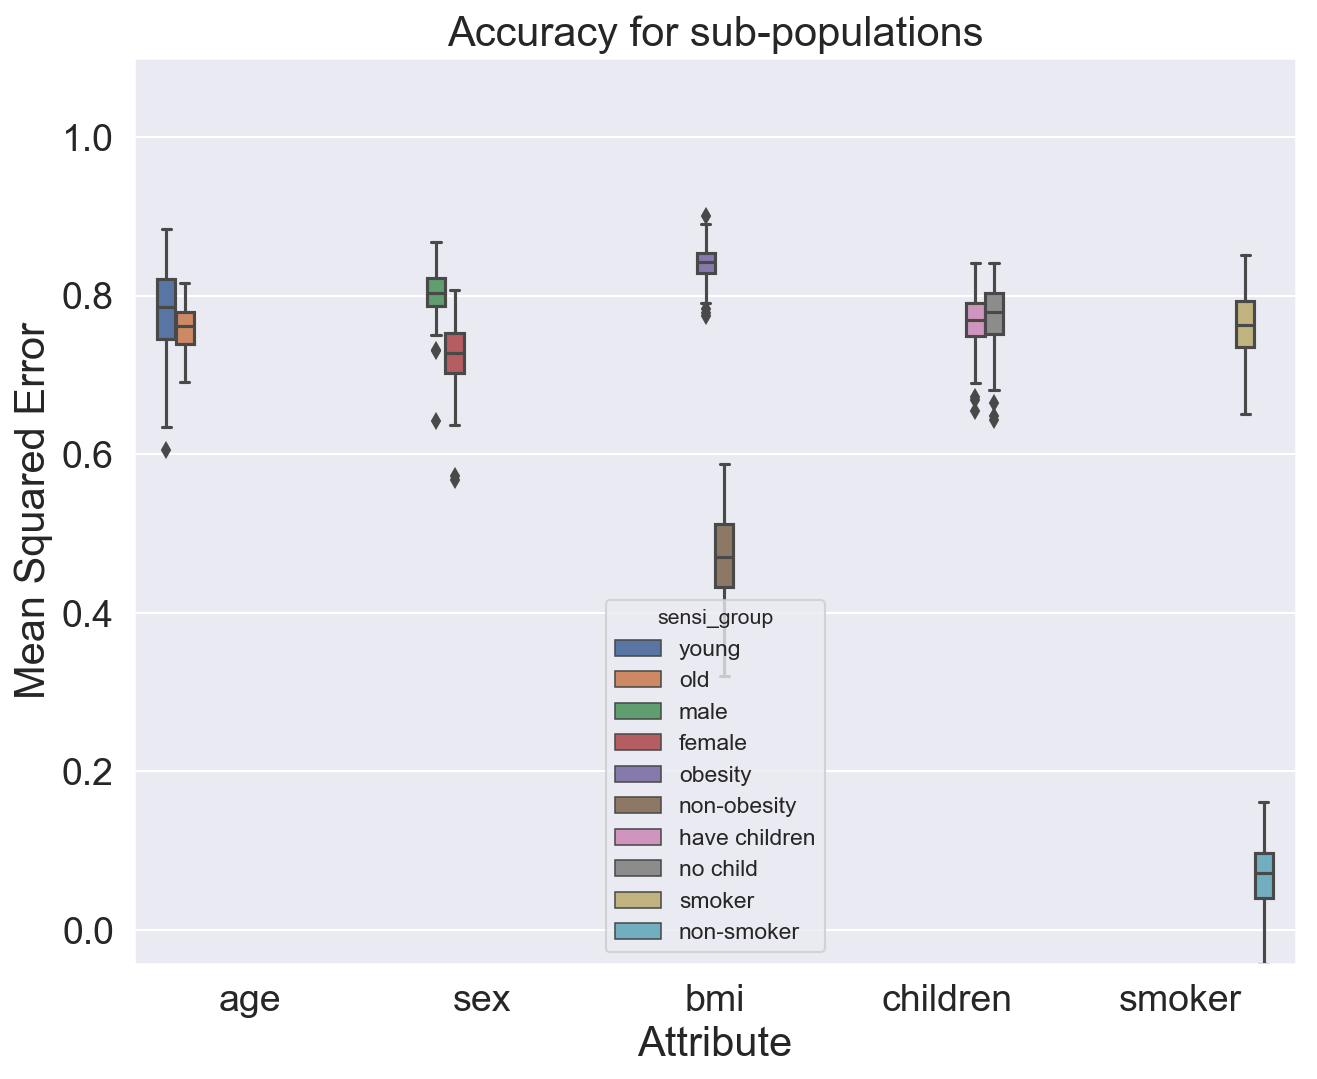

In [15]:
plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="sensi_att", y="group_acc", hue="sensi_group", data=rf_res)
plt.xlabel("Attribute", fontsize=20)
plt.ylabel("Mean Squared Error", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([min(rf_res["group_acc"]),1.1])
plt.title("Accuracy for sub-populations", fontsize=20)
plt.savefig("Accuracy_rf.png")

## Visualize group fairness for different train-test splits

### Linear Regression

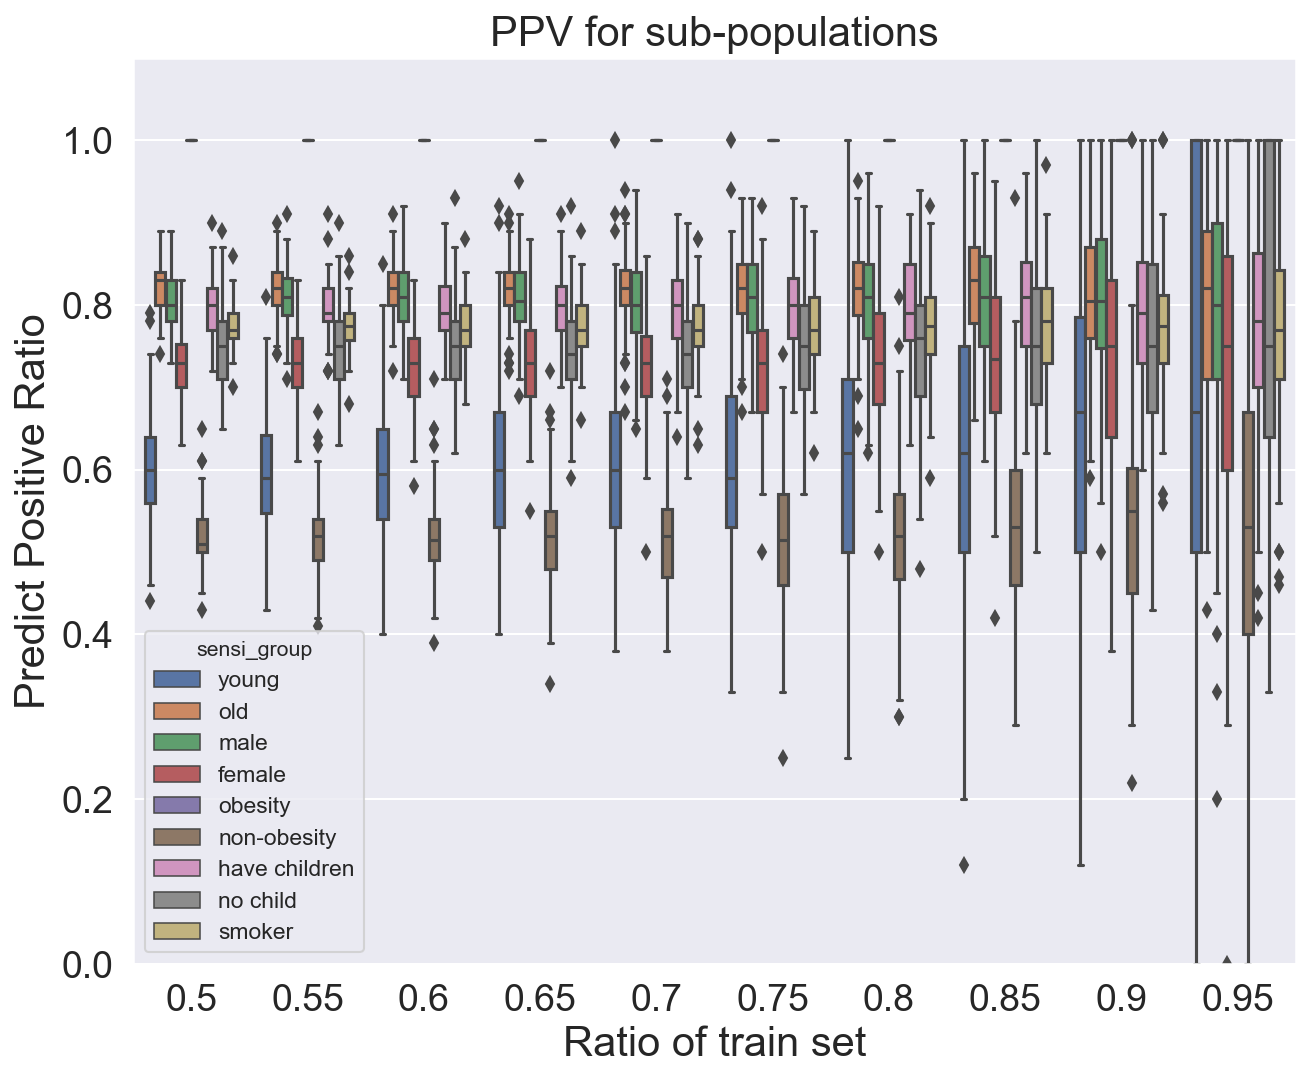

In [18]:
lr_gf_res = gf_res[(gf_res["regression_model"]=="linear") & (gf_res["group_ppv"]!=-1)]
plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="train_ratio", y="group_ppv", hue="sensi_group", data=lr_gf_res)
plt.xlabel("Ratio of train set", fontsize=20)
plt.ylabel("Predict Positive Ratio", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([min(lr_gf_res["group_ppv"]),1.1])
plt.title("PPV for sub-populations", fontsize=20)
plt.savefig("GF_lr.png")

### Polynomial Regression

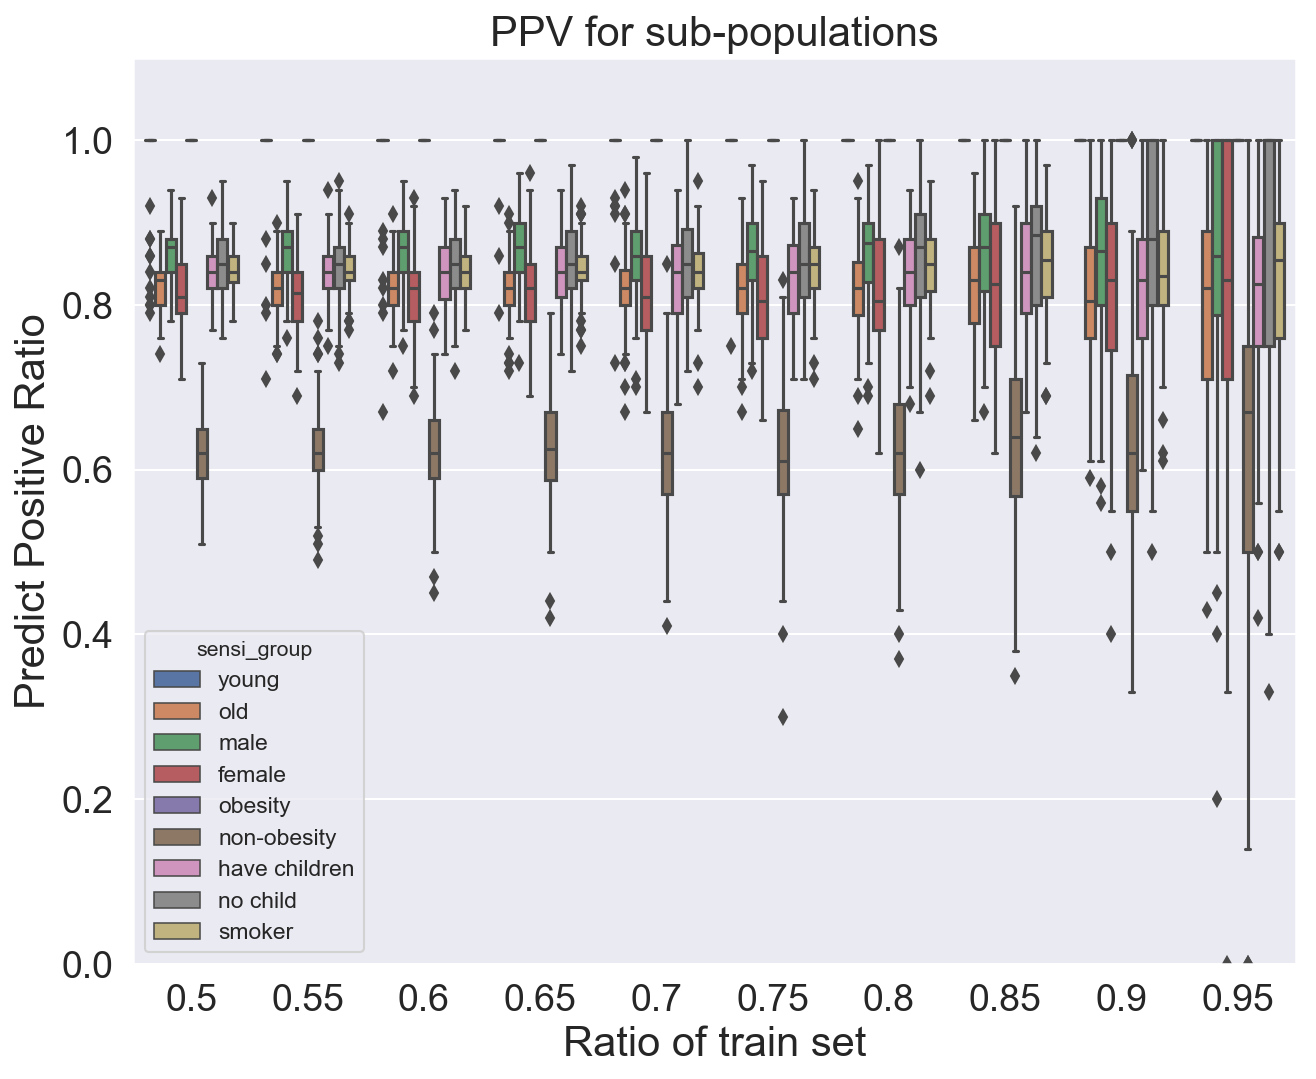

In [19]:
pl_gf_res = gf_res[(gf_res["regression_model"]=="polynomial") & (gf_res["group_ppv"]!=-1)]
plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="train_ratio", y="group_ppv", hue="sensi_group", data=pl_gf_res)
plt.xlabel("Ratio of train set", fontsize=20)
plt.ylabel("Predict Positive Ratio", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([min(pl_gf_res["group_ppv"]),1.1])
plt.title("PPV for sub-populations", fontsize=20)
plt.savefig("GF_pl.png")

### Random Forest

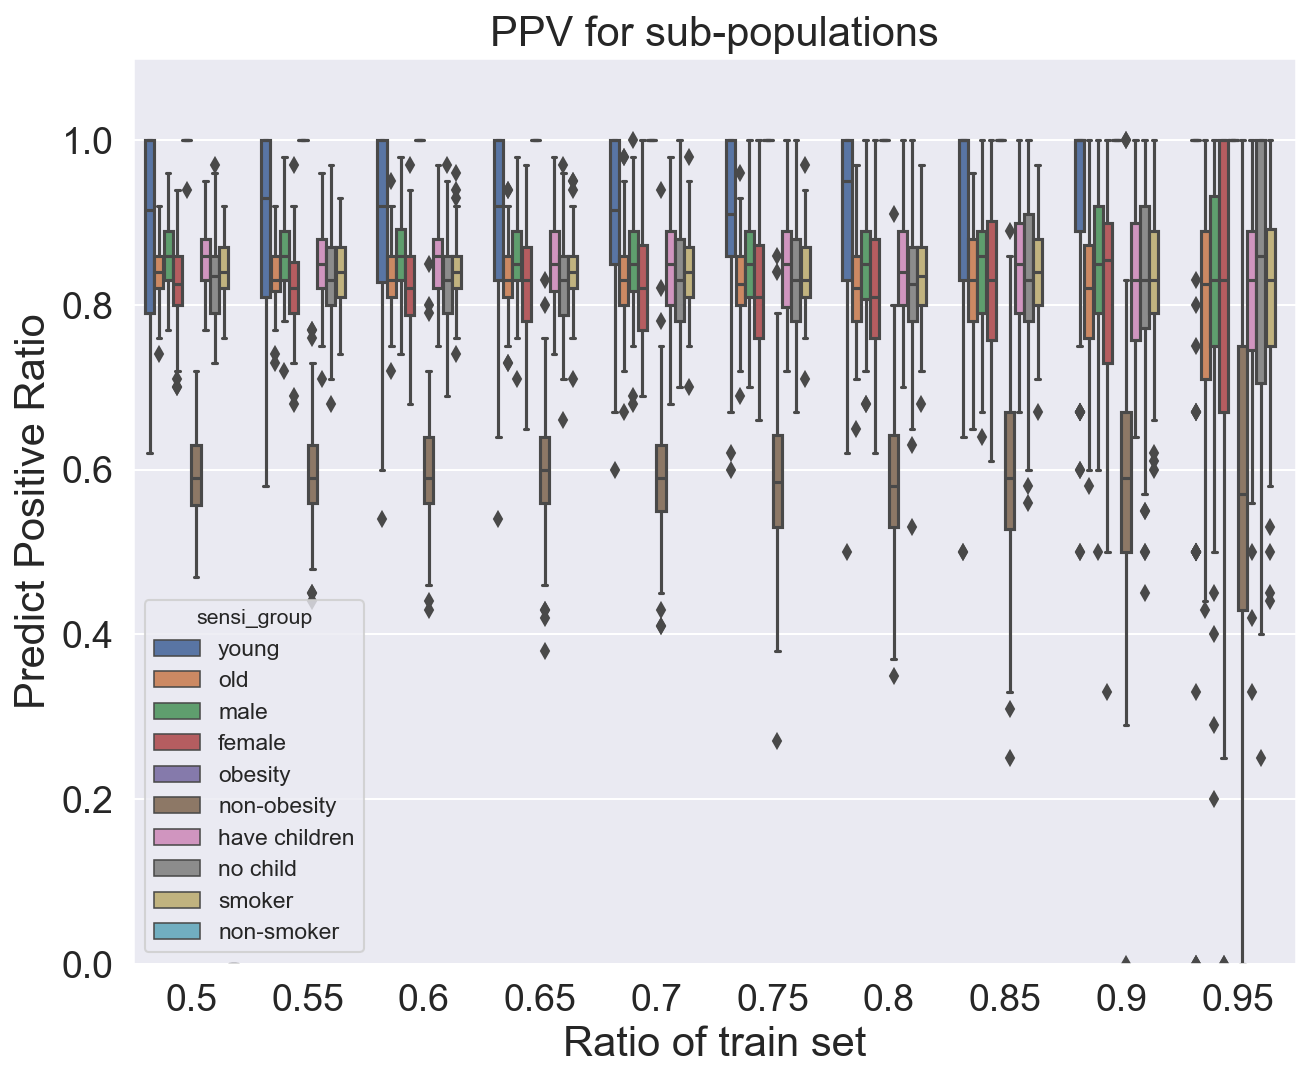

In [20]:
rf_gf_res = gf_res[(gf_res["regression_model"]=="random") & (gf_res["group_ppv"]!=-1)]
plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="train_ratio", y="group_ppv", hue="sensi_group", data=rf_gf_res)
plt.xlabel("Ratio of train set", fontsize=20)
plt.ylabel("Predict Positive Ratio", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([min(pl_gf_res["group_ppv"]),1.1])
plt.title("PPV for sub-populations", fontsize=20)
plt.savefig("GF_rf.png")

## Diversity
- Diversity component shows the representation of different groups defined by the above sensitve attributes.
- We show the representations for top-10 and over-all results.